In [ ]:
#all_slow

# Replication of Sundin et al, ICML 2019

In [ ]:
from asbe.base import *
from asbe.models import *
from asbe.estimators import *
from econml.orf import DMLOrthoForest
from econml.dml import CausalForestDML
from causalml.inference.nn import CEVAE
from openbt.openbt import OPENBT
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from copy import deepcopy
import econml
from causalml.dataset import synthetic_data
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [ ]:
def categorical2indicator(data, name, categorical_max=4):
    '''
    Transforms categorical variable with name 'name' form a data frame to indicator variables
    
    Taken from https://github.com/IirisSundin/active-learning-for-decision-making/blob/e0c83f58181f81da2f867da4c49f1333fa7d0ae6/src/util.py#L14
    '''
    values = data[name].values
    values[values>= categorical_max] = categorical_max
    uni = np.unique(values)
    for i, value in enumerate(uni):
        data[name+'.'+str(i)] = np.array((values==value), dtype=int)
    data.drop(name, axis=1)
    return data

def prepare_data(row_to_test, random_state,categorical_max=2):
    df = pd.read_csv("./data/ihdp_rc.csv")
    #names = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [f'x{x}' for x in range(25)])
    df = categorical2indicator(df, 'birth.o', categorical_max=categorical_max)
    cnames = set(df.columns) - set(["y_factual", "y_cfactual", "treatment"])
    #X = df.loc[:,"x0":].to_numpy()
    df["first"] = df["first"] - 1
    
    # Creating training data
    X_test = df.loc[row_to_test, cnames]
    y_test = df.loc[row_to_test, "y_factual"]
    t_test = df.loc[row_to_test, "treatment"]
    ite_test = np.where(
                   df.loc[row_to_test, "treatment"] == 1,
                   df.loc[row_to_test, 'y_factual'] -  df.loc[row_to_test, "y_cfactual"],
                   df.loc[row_to_test, 'y_cfactual'] - df.loc[row_to_test, "y_factual"])
    
    df.drop(row_to_test, axis=0, inplace=True)
    X = df[cnames]
    t = df["treatment"].to_numpy()
    y = df["y_factual"].to_numpy()
    y1 = np.where(df["treatment"] == 1,
                   df['y_factual'],
                   df['y_cfactual'])
    y0 = np.where(df["treatment"] == 0,
                   df['y_factual'],
                   df['y_cfactual'])
    ite = np.where(df["treatment"] == 1,
                   df['y_factual'] - df["y_cfactual"],
                   df['y_cfactual'] - df["y_factual"])
    
    scalers = {}
    X_train, X_pool, y_train, y_pool, t_train, t_pool, \
     y1_train, y1_pool, y0_train, y0_pool, ite_train, ite_pool = train_test_split(X, y, t,
                                                                         y1, 
                                                                         y0,
                                                                         ite,
                                                                         test_size = 646,
                                                                         random_state=random_state)
    for col in ['bw','nnhealth', 'preterm', 'b.head','momage']:
        scalers[col] = StandardScaler()
        X_train[col] = scalers[col].fit_transform(X_train[col].to_numpy().reshape(-1,1))
        X_pool[col] = scalers[col].transform(X_pool[col].to_numpy().reshape(-1,1))
        X_test[col] = scalers[col].transform(X_test[col].reshape(-1,1))    
    #X_train, X_pool, y_train, y_pool = X[], X_pool, y_train, y_pool
    ds = {"X_training": X_train.to_numpy(),
     "y_training": y_train,
     "t_training": t_train,
     "X_pool": X_pool.to_numpy(), 
     "y_pool": y_pool,
     "t_pool": t_pool,
     "y1_pool": y1_pool,
     "y0_pool": y0_pool,
     "X_test": X_test.to_numpy().reshape(1, -1),
     "y_test": y_test,
     "t_test": t_test,
      "ite_test": ite_test.reshape(1, -1)
     }
    return ds

In [ ]:
dt = prepare_data(row_to_test=1, random_state=1)

In [ ]:
dt["X_training"].shape

In [ ]:
import GPy

In [ ]:
class GPyEstimator(BaseITEEstimator):
    def train(self, **kwargs):
        d = kwargs["X_training"].shape[1]
        prior = GPy.core.parameterization.priors.Gamma(a=1.5,b=3.0)
        kern = GPy.kern.RBF(input_dim=d, ARD=True)
        kern.variance.set_prior(prior)
        kern.lengthscale.set_prior(prior)
        lik1 = GPy.likelihoods.Gaussian()
        lik1.variance.set_prior(prior)
        lik_expert = GPy.likelihoods.Gaussian()
        lik_expert.variance.set_prior(prior)
        lik = GPy.likelihoods.MixedNoise([lik1, lik_expert])
        m = GPy.core.GP(X = predictors, Y = outcomes, kernel=kern, likelihood=lik)
        m.optimize()

In [ ]:
res = {}
for i in range(1):
    for d in range(50):
        ds = prepare_data(d+1, i)
        asl = BaseActiveLearner(estimator = GPEstimator(model = GaussianProcessRegressor(ConstantKernel()*RBF(np.ones(ds["X_training"].shape[1],))),
                                                 two_model=True,
                                                            ps_model=None),
                                acquisition_function=[RandomAcquisitionFunction(name="random"),
                                                      UncertaintyAcquisitionFunction(name="unc"),
                                                      TypeSAcquistionFunction(name="type_s"),
                                                      EMCMAcquisitionFunction(name="emcm")],
                                assignment_function=BaseAssignmentFunction(),
                                stopping_function = None,
                                dataset=ds,
                               al_steps=5)
        _ = asl.simulate(no_query=1, metric=["decision", "PEHE"])
        res[f"{i}_{d}"] =  pd.DataFrame(asl.simulation_results)
        res[f"{i}_{d}"]["sim"] = i
        res[f"{i}_{d}"]["data"] = d
        print(f"D {d} is done")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 15)

In [ ]:
pd.concat([x.loc["PEHE"].apply(pd.Series).T for x in res.values()]).reset_index().groupby('index').mean()

,random_1,unc_1,type_s_1,emcm_1,sim,data
index,,,,,,
0,NaN,NaN,NaN,NaN,0.0,24.5
1,4.856879,4.856879,4.856879,4.856879,NaN,NaN
2,4.520318,4.783990,4.459509,4.661603,NaN,NaN
3,5.966706,5.830186,6.096363,5.773085,NaN,NaN
4,5.384808,4.917060,4.834906,4.825518,NaN,NaN
5,4.957736,4.161023,4.738927,4.755389,NaN,NaN


\begin{tabular}{l}
\toprule
Empty DataFrame
Columns: Index([], dtype='object')
Index: Index(['PEHE', 'decision'], dtype='object', name='index') \\
\bottomrule
\end{tabular}



ZeroDivisionError: integer division or modulo by zero

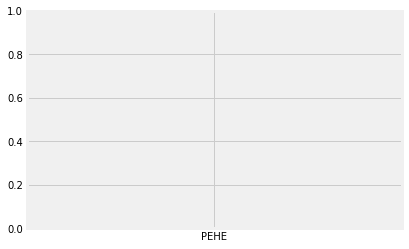

In [ ]:
resdf = pd.concat(res.values())

resdf.reset_index(inplace=True)

print(resdf.groupby(["data", "index"])["random_1", "unc_1", "type_s_1", "emcm_1"].mean().loc[0].to_latex())

plt.plot(resdf.groupby(["index"])["random_1", "unc_1", "type_s_1", "emcm_1"].mean())

In [ ]:
res